# Developing VeriBot, An AI social media posts credibility classifier

# Getting the data

## Scrapping fact-checked social media posts from Politifact
Through manual inspection of [Politifact](https://www.politifact.com/) I was able to notice that the fact-checks section of the website has about 789 pages. The general structure of the urls to access those pages is `https://www.politifact.com/factchecks/list/?page={page_number}` where `page_number` is the current page number. I will be using a combination of `BeautifulSoup` and `requests` libraries to scrap this website.

In [1]:
# Connect to Google drive
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
# Required libraries
from bs4 import BeautifulSoup
import requests

In [ ]:
BASE_URL = "https://www.politifact.com"
FACT_CHECKS_URL = f"{BASE_URL}/factchecks/list/?page="
PAGE_RANGE = 787
PROJECT_DIR = "/content/drive/MyDrive/projects/veribot"

In [ ]:
# Get generate urls to all 787 fact-check pages
def generate_page_urls():
  page_urls = []
  for page_number in range(1, PAGE_RANGE + 1):
    url = f'{FACT_CHECKS_URL}{page_number}'
    page_urls.append(url)

  return page_urls

page_urls = generate_page_urls()
page_urls[:5]

#### Things to note
These are the different categories that the journalists at Politifact put various social media posts based on their truthiness:
- **TRUE** - The statement is accurate and there's nothing significant missing.
- **MOSTLY TRUE** - The statement is accurate but needs clarification or additional information.
- **HALF TRUE** - The statement is partially accurate but leaves out important details or takes things out of context.
- **MOSTLY FALSE** - The statement contains an element of truth but ignores critical facts that would give a different impression.
- **FALSE** - The statement is not accurate.
- **PANTS ON FIRE** - The statement is not accurate and makes a ridiculous claim.

Based on this I will classify posts that are **true**, **mostly true**, and **half true** as `credible` and the rest as `incredible`.

In [ ]:
import csv

# Create a function to get a binary number from target -- 1 = True and 0 = False
def get_binary_credibility(text):
  credible = ['half-true', 'mostly-true', 'true']
  if text in credible:
    return 'credible'
  if text in ['full-flop', 'half-flip', 'no-flip']:
    return 'no-classification'
  else:
    return 'incredible'

# Get all the posts on a single page
def get_page_posts(link):
  res = requests.get(link)
  # Raise an exception for HTTP errors (e.g., 404)
  res.raise_for_status()

  soup = BeautifulSoup(res.text, 'html.parser')

  statements = soup.find_all('article', attrs={'class': 'm-statement'})
  posts = list()
  for statement in statements:
    source = statement.find('a', attrs={'class': 'm-statement__name'}).string.strip()
    content = statement.find('div', attrs={'class': 'm-statement__quote'}).a.string.strip()
    classification = statement.find('div', attrs={'class': 'm-statement__meter'}).find('img', attrs={'class': 'c-image__original'}).get('alt')

    # convert the classification to `credible` or `incredible`
    classification = get_binary_credibility(classification)
    if classification == 'no-classification':
      continue

    posts.append({'source': source, 'content': content, 'classification': classification})

  return posts

# Specify the path to save the CSV file in Google Colab's local file system
csv_file_path_colab = '/content/posts.csv'

# Get all the posts on all the pages
def get_posts(links):
  # Open the CSV file in write mode and create a CSV writer
  with open(csv_file_path_colab, 'w', newline='', encoding='utf-8') as csvfile:
    fieldnames = ['source', 'content', 'classification']
    writer = csv.DictWriter(csvfile, fieldnames=fieldnames)

    # Write the CSV header
    writer.writeheader()

    # Loop through the links and fetch and process posts
    for index, link in enumerate(links):
      try:
        print(f"{index}. Fetching: {link}")
        posts = get_page_posts(link)
        # Write the post data to the CSV file
        writer.writerows(posts)
      except Exception as e:
          # Handle errors as needed
          print(f"Error processing {link}: {e}")
          continue

get_posts(page_urls)

In [ ]:
# Specify the path to save the CSV file in Google Drive
csv_file_path_drive = f'{PROJECT_DIR}/datasets/posts.csv'

# Move the CSV file from Colab's file system to Google Drive
!mv "{csv_file_path_colab}" "{csv_file_path_drive}"

print(f"CSV file has been moved to Google Drive: {csv_file_path_drive}")

# Developing the model

## Data loading, exploration and cleaning

In [2]:
import pandas as pd

PROJECT_PATH = "/content/drive/MyDrive/projects/veribot"
MODELS_PATH = f'{PROJECT_PATH}/models'
DATASETS_PATH = f'{PROJECT_PATH}/datasets'

In [3]:
filepath = f'{DATASETS_PATH}/posts.csv'
posts_df = pd.read_csv(filepath)

In [4]:
# get the first 5 rows
posts_df.head()

,source,content,classification
0,Facebook posts,A video shows children disappearing from insid...,incredible
1,Instagram posts,New York City is spraying unsafe pesticides to...,incredible
2,Instagram posts,A Sept. 20 video shows President Joe Biden’s b...,incredible
3,Facebook posts,"""En ciertos estados el gobierno de Estados Uni...",incredible
4,TikTok posts,Arizona Senate “indicted” Gov. Katie Hobbs.,incredible


In [5]:
# get the last 5 rows
posts_df.tail()

,source,content,classification
23306,Joe Biden,"""You know we can't just pull out now... The tr...",credible
23307,Joe Biden,"""The president is brain-dead.""",incredible
23308,Mitt Romney,"""(McCain) was opposed to ethanol. Now he's for...",credible
23309,Mitt Romney,"""(McCain) said he was opposed to overturning R...",credible
23310,John Edwards,An estimated 56 million Americans don't have b...,credible


In [6]:
# how many records are there in total?
posts_df.shape[0]

23311

In [7]:
# check the number of classifications available
posts_df['classification'].value_counts()

incredible    13572
credible       9739
Name: classification, dtype: int64

In [8]:
# remove rows containing a classification of full-flop, half-flop or no-flip
values_to_remove = ['full-flop', 'half-flip', 'no-flip']
mask = ~posts_df['classification'].isin(values_to_remove)
posts_df = posts_df[mask]
posts_df['classification'].value_counts()

incredible    13572
credible       9739
Name: classification, dtype: int64

It's already clear from these numbers that people don't like to tell the truth very much on social media. Let me put this in a bar chart.

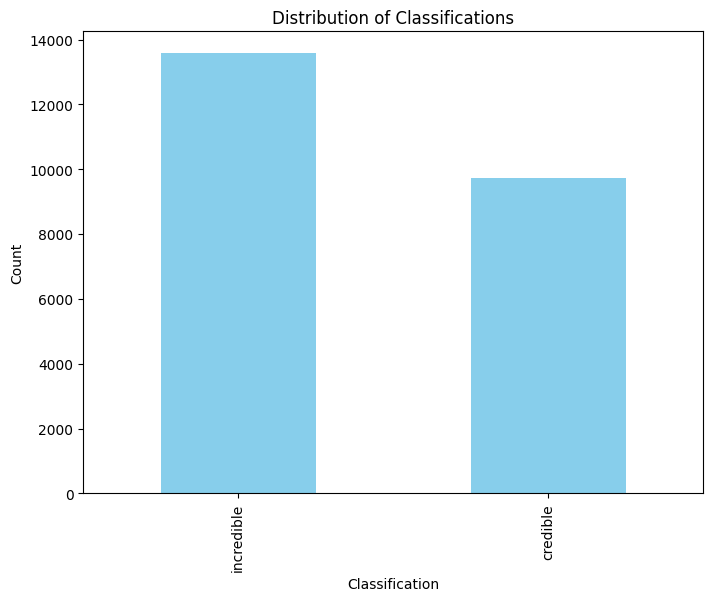

In [9]:
import matplotlib.pyplot as plt

classification_counts = posts_df['classification'].value_counts()

# Create a bar chart
plt.figure(figsize=(8, 6))  # Optional: Adjust the figure size
classification_counts.plot(kind='bar', color='skyblue')

# Add labels and a title
plt.xlabel('Classification')
plt.ylabel('Count')
plt.title('Distribution of Classifications')

# Show the plot
plt.show()

In [10]:
# check if there's any missing data from the dataset
posts_df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 23311 entries, 0 to 23310
Data columns (total 3 columns):
 #   Column          Non-Null Count  Dtype 
---  ------          --------------  ----- 
 0   source          23311 non-null  object
 1   content         23311 non-null  object
 2   classification  23311 non-null  object
dtypes: object(3)
memory usage: 728.5+ KB


The total number of rows in the dataset($23310$) is equal to the total number of non-null rows in each column. This mean there are no missing values.

In [11]:
# Another confirmation that there are no missing values.
posts_df.isna().sum()

source            0
content           0
classification    0
dtype: int64

## Clean the text data

In [12]:
# required libraries
import re
import string
import nltk
from nltk.corpus import stopwords
from nltk.stem import WordNetLemmatizer

# download NLTK stopwords
nltk.download('stopwords')
nltk.download('wordnet')

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.
[nltk_data] Downloading package wordnet to /root/nltk_data...


True

In [13]:
# define a function to clean the text
def clean_doc(doc):
    # Remove HTML tags using regex
    doc = re.sub(r'<[^>]+>', '', doc)

    # Convert text to lowercase
    doc = doc.lower()

    # Split into tokens by white space
    tokens = doc.split()

    # Prepare regex for char filtering
    re_punc = re.compile('[%s]' % re.escape(string.punctuation))

    # Remove punctuation from each word
    tokens = [re_punc.sub('', w) for w in tokens]

    # Remove non-alphabetic tokens
    tokens = [word for word in tokens if word.isalpha()]

    # Initialize the WordNet Lemmatizer
    lemmatizer = WordNetLemmatizer()

    # Perform lemmatization on each word
    tokens = [lemmatizer.lemmatize(word) for word in tokens]

    # Filter out stop words
    stop_words = set(stopwords.words('english'))
    tokens = [w for w in tokens if not w in stop_words]

    # Filter out short tokens
    tokens = [word for word in tokens if len(word) > 1]

    # Join the tokens back into a single string
    cleaned_text = ' '.join(tokens)

    return cleaned_text

In [14]:
# clean the text
posts_df['source'] = posts_df['source'].apply(clean_doc)
posts_df['content'] = posts_df['content'].apply(clean_doc)
posts_df.head()

,source,content,classification
0,facebook post,video show child disappearing inside school bus,incredible
1,instagram post,new york city spraying unsafe pesticide combat...,incredible
2,instagram post,sept video show president joe body double,incredible
3,facebook post,en ciertos estados el gobierno de estados unid...,incredible
4,tiktok post,arizona senate gov katie hobbs,incredible


In [15]:
# Combine the source and content into a single column `combined_content`
posts_df['combined_content'] = (posts_df['source'] + ' ' + posts_df['content'])
posts_df.head()

,source,content,classification,combined_content
0,facebook post,video show child disappearing inside school bus,incredible,facebook post video show child disappearing in...
1,instagram post,new york city spraying unsafe pesticide combat...,incredible,instagram post new york city spraying unsafe p...
2,instagram post,sept video show president joe body double,incredible,instagram post sept video show president joe b...
3,facebook post,en ciertos estados el gobierno de estados unid...,incredible,facebook post en ciertos estados el gobierno d...
4,tiktok post,arizona senate gov katie hobbs,incredible,tiktok post arizona senate gov katie hobbs


In [16]:
import numpy as np

# split the data into independent(X) and dependent(y) variables
X = posts_df['combined_content'].values
y = posts_df['classification'].values

In [17]:
X[:5]

array(['facebook post video show child disappearing inside school bus',
       'instagram post new york city spraying unsafe pesticide combat west nile virus',
       'instagram post sept video show president joe body double',
       'facebook post en ciertos estados el gobierno de estados unidos comprará los paneles por ti te los dará sin ningún costo en caso de que te pas energía solar en la próximas semanas',
       'tiktok post arizona senate gov katie hobbs'], dtype=object)

In [18]:
y[:5]

array(['incredible', 'incredible', 'incredible', 'incredible',
       'incredible'], dtype=object)

## Comparing machine learning models
I will be using cross validation to train various machine learning models and compare their accuracy scores.

In [19]:
# required libraries
import numpy as np
from sklearn.model_selection import cross_val_score, train_test_split
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer
from sklearn.linear_model import LogisticRegression
from sklearn.naive_bayes import MultinomialNB
from sklearn.neighbors import KNeighborsClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score

In [20]:
# Transform the training data
tfidf = TfidfVectorizer(max_features=5000)

In [21]:
# Transform the test data
X_tfidf = tfidf.fit_transform(X).toarray()
X_tfidf

array([[0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       ...,
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.]])

In [22]:
# Create a dictionary to store accuracy scores
scores = {}

### Logistic Regression

In [23]:
lr = LogisticRegression(solver='liblinear')
scores["Logistic Regression"] = cross_val_score(lr, X_tfidf, y, cv=5, scoring='accuracy').mean()
scores["Logistic Regression"]

0.6028020729286009

### KNN

In [24]:
knn_classifier = KNeighborsClassifier(n_neighbors=5)
scores["KNN"] = cross_val_score(knn_classifier, X_tfidf, y, cv=10, scoring='accuracy').mean()
scores["KNN"]

0.6030177199988521

### Random Forests


In [25]:
rfc = RandomForestClassifier(n_estimators = 10, criterion = 'entropy', random_state=42)
scores["Random Forests"] = cross_val_score(rfc, X_tfidf, y, cv=5, scoring='accuracy').mean()
scores["Random Forests"]

0.6141260926377804

### Naive Bayes(Multinomial)

In [26]:
mnb = MultinomialNB()
scores["Naive Bayes"] = cross_val_score(mnb, X_tfidf, y, cv=5, scoring='accuracy').mean()
scores["Naive Bayes"]

0.6153288578551284

### Compare the scores

In [27]:
scores

{'Logistic Regression': 0.6028020729286009,
 'KNN': 0.6030177199988521,
 'Random Forests': 0.6141260926377804,
 'Naive Bayes': 0.6153288578551284}

In [28]:
import matplotlib.pyplot as plt

# Create a DataFrame from the dictionary
scores_df = pd.DataFrame(list(scores.items()), columns=['Model', 'Score'])
scores_df

,Model,Score
0,Logistic Regression,0.602802
1,KNN,0.603018
2,Random Forests,0.614126
3,Naive Bayes,0.615329


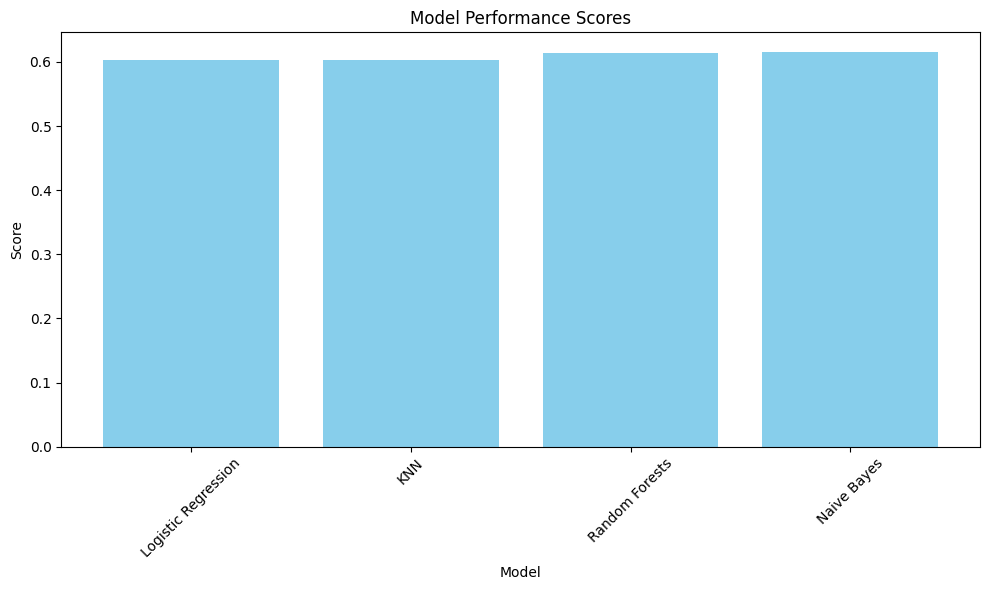

In [29]:
# Create a bar chart
plt.figure(figsize=(10, 6))
plt.bar(scores_df['Model'], scores_df['Score'], color='skyblue')
plt.xlabel('Model')
plt.ylabel('Score')
plt.title('Model Performance Scores')
plt.xticks(rotation=45)
plt.tight_layout()

# Show the bar chart
plt.show()


## Developing a deep learning model

In [30]:
from keras.preprocessing.text import Tokenizer
from keras.preprocessing.sequence import pad_sequences

In [31]:
# instantiate the tokenizer
tokenizer = Tokenizer()
tokenizer.fit_on_texts(X)

In [32]:
# What is the vocabulary size?
print(f'Vocabulary size = {len(tokenizer.word_index) + 1}')

Vocabulary size = 19168


In [33]:
# convert the dependent variable into integer sequences
X_final = tokenizer.texts_to_sequences(X)
X_final[:5]

[[3, 2, 83, 25, 61, 8161, 1550, 41, 1511],
 [43, 2, 20, 191, 68, 6760, 3428, 4663, 1890, 293, 10862, 627],
 [43, 2, 2186, 83, 25, 14, 29, 797, 814],
 [3,
  2,
  798,
  8162,
  2472,
  671,
  8163,
  278,
  2472,
  2878,
  10863,
  1026,
  10864,
  2473,
  10865,
  5837,
  1026,
  10866,
  5140,
  8164,
  10867,
  798,
  10868,
  278,
  997,
  5837,
  713,
  10869,
  1047,
  798,
  507,
  10870,
  10871],
 [435, 2, 522, 79, 103, 1891, 3222]]

In [34]:
# What is the maximum sequence length?
# This number is important before padding the sequences so that they are of the
# the same length
max_seq_length = max([len(seq) for seq in X_final])
max_seq_length

45

In [35]:
# Pad sequences so that they are of the same length
X_final_padded = pad_sequences(X_final, maxlen=max_seq_length, padding="post")
X_final_padded[:5]

array([[    3,     2,    83,    25,    61,  8161,  1550,    41,  1511,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0],
       [   43,     2,    20,   191,    68,  6760,  3428,  4663,  1890,
          293, 10862,   627,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0],
       [   43,     2,  2186,    83,    25,    14,    29,   797,   814,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
    

In [36]:
# label encode the target variable y
from sklearn.preprocessing import LabelEncoder

label_encoder = LabelEncoder()
y_encoded = label_encoder.fit_transform(y)
y_encoded[:5]

array([1, 1, 1, 1, 1])

In [37]:
# what were the infered labels?
label_encoder.classes_

array(['credible', 'incredible'], dtype=object)

In [38]:
# Split the data into training and validation sets
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X_final_padded,
                                                   y_encoded,
                                                   test_size = 0.2,
                                                   random_state = 42)

In [39]:
# define the model
from keras.layers import Input, Embedding, SpatialDropout1D, LSTM, Bidirectional, Dropout, Dense, Conv1D
from keras.models import Model

vocab_size = len(tokenizer.word_index) + 1

def create_model(vocab_size, max_seq_length):
  input_layer = Input(shape=(max_seq_length,))
  embedding = Embedding(vocab_size, 100, input_length=max_seq_length)(input_layer)
  dropout_1 = SpatialDropout1D(0.2)(embedding)
  conv1 = Conv1D(64, 5, activation='relu')(dropout_1)
  bidirectional = Bidirectional(LSTM(64, dropout=0.2, recurrent_dropout=0.2))(conv1)
  dense_1 = Dense(512, activation='relu')(bidirectional)
  dropout_2 = Dropout(0.5)(dense_1)
  dense_2 = Dense(512, activation='relu')(dropout_2)
  outputs = Dense(1, activation='sigmoid')(dense_2)
  model = Model(input_layer, outputs)

  model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])
  model.summary()

  return model


In [40]:
model = create_model(vocab_size, max_seq_length)

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 45)]              0         
                                                                 
 embedding (Embedding)       (None, 45, 100)           1916800   
                                                                 
 spatial_dropout1d (Spatial  (None, 45, 100)           0         
 Dropout1D)                                                      
                                                                 
 conv1d (Conv1D)             (None, 41, 64)            32064     
                                                                 
 bidirectional (Bidirection  (None, 128)               66048     
 al)                                                             
                                                                 
 dense (Dense)               (None, 512)               66048 

In [42]:
history = model.fit(X_train,
                    y_train,
                    epochs = 100,
                    batch_size = 128,
                    validation_data = (X_test, y_test))

Epoch 1/100
146/146 [==============================] - 47s 275ms/step - loss: 0.5823 - accuracy: 0.6665 - val_loss: 0.5289 - val_accuracy: 0.7165
Epoch 2/100
146/146 [==============================] - 38s 259ms/step - loss: 0.4574 - accuracy: 0.7812 - val_loss: 0.5510 - val_accuracy: 0.7141
Epoch 3/100
146/146 [==============================] - 37s 251ms/step - loss: 0.3337 - accuracy: 0.8524 - val_loss: 0.6696 - val_accuracy: 0.6993
Epoch 4/100
146/146 [==============================] - 39s 271ms/step - loss: 0.2109 - accuracy: 0.9122 - val_loss: 0.9172 - val_accuracy: 0.6755
Epoch 5/100
146/146 [==============================] - 40s 271ms/step - loss: 0.1232 - accuracy: 0.9509 - val_loss: 1.3718 - val_accuracy: 0.6682
Epoch 6/100
146/146 [==============================] - 38s 260ms/step - loss: 0.0795 - accuracy: 0.9699 - val_loss: 1.5803 - val_accuracy: 0.6655
Epoch 7/100
146/146 [==============================] - 39s 264ms/step - loss: 0.0524 - accuracy: 0.9807 - val_loss: 1.9335 -

## Conclusion
The deep learning model produced the best accuracy out of all the models that I tested. Therefore, I will use this model to build the web application for this project. It is concerning that all of the models could not achieve a higher accuracy which probably suggests the lack of suitability of these models to determine the credibility of social media posts, among other things.

### Saving the best model and related objects

In [43]:
from pickle import dump

# save the prediction model
model.save(f'{MODELS_PATH}/classifier.keras', save_format='keras')
model.save(f'{MODELS_PATH}/classifier.h5', save_format='h5')

# save the tokenizer
dump(tokenizer, open(f'{MODELS_PATH}/tokenizer.pkl', 'wb'))

# save the label encoder
dump(label_encoder, open(f'{MODELS_PATH}/label_encoder.pkl', 'wb'))

/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3000: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


## Making new predictions using the deep learning model

In [48]:
# required libraries
import re
import string
import nltk
from nltk.corpus import stopwords
from nltk.stem import WordNetLemmatizer
from keras.preprocessing.sequence import pad_sequences

# download NLTK stopwords
nltk.download('stopwords')
nltk.download('wordnet')

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!


True

In [46]:
# define a function to clean the text
def clean_doc(doc):
    # Remove HTML tags using regex
    doc = re.sub(r'<[^>]+>', '', doc)

    # Convert text to lowercase
    doc = doc.lower()

    # Split into tokens by white space
    tokens = doc.split()

    # Prepare regex for char filtering
    re_punc = re.compile('[%s]' % re.escape(string.punctuation))

    # Remove punctuation from each word
    tokens = [re_punc.sub('', w) for w in tokens]

    # Remove non-alphabetic tokens
    tokens = [word for word in tokens if word.isalpha()]

    # Initialize the WordNet Lemmatizer
    lemmatizer = WordNetLemmatizer()

    # Perform lemmatization on each word
    tokens = [lemmatizer.lemmatize(word) for word in tokens]

    # Filter out stop words
    stop_words = set(stopwords.words('english'))
    tokens = [w for w in tokens if not w in stop_words]

    # Filter out short tokens
    tokens = [word for word in tokens if len(word) > 1]

    # Join the tokens back into a single string
    cleaned_text = ' '.join(tokens)

    return cleaned_text

In [57]:
# create a function to make the prediction
def get_prediction(source, content, classifier, tokenizer, label_encoder):
  post = f'{source} {content}'

  post = clean_doc(post)

  post = [post]

  post = tokenizer.texts_to_sequences(post)

  max_seq_length = 45
  post = pad_sequences(post, maxlen=max_seq_length, padding="post")

  result = dict()

  result["probability"] = model.predict(post)[0][0]

  if result["probability"] >= 0.5:
      result["classification"] = label_encoder.inverse_transform([1])[0]
  else:
      result["classification"] = label_encoder.inverse_transform([0])[0]

  return result

In [58]:
result = get_prediction("Gavin Newsom",
                      "'We are more energy independent today' under President Joe Biden",
                      model,
                      tokenizer,
                      label_encoder)
result

1/1 [==============================] - 0s 31ms/step


{'probability': 2.2666897e-09, 'classification': 'credible'}